<a href="https://colab.research.google.com/github/Nicolas-BZRD/NLP-Classification-Toxic-Comments/blob/main/Classification_toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Regex to clean up sentences
import re

#tf_idf
import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.utils import np_utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 500

# Importing data

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Google_Colab/NLP_Classification_Toxic_Comments/train.csv')
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


# First look

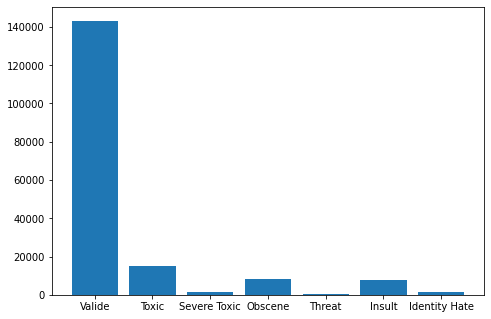

In [4]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['Valide', 'Toxic', 'Severe Toxic','Obscene', 'Threat', 'Insult', 'Identity Hate']
values = [
          len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)]),
          data['toxic'].value_counts()[1],
          data['severe_toxic'].value_counts()[1],
          data['obscene'].value_counts()[1],
          data['threat'].value_counts()[1],
          data['insult'].value_counts()[1],
          data['identity_hate'].value_counts()[1],
          ]
ax.bar(types,values)
plt.show()

In [5]:
print("Number comments in dataframe : {}".format(len(data.index)))

Number comments in dataframe : 159571


Compute max length of a comment:

In [6]:
max_length = max(len(comment.split()) for comment in data["comment_text"])

print("Max size comment : {}".format(max_length))

Max size comment : 1411


Average size of a comment:

In [7]:
average_size = 0
for line in data["comment_text"]:
  words = line.split()
  average_size = average_size + len(words)
average_size = average_size/len(data.index)

print("Average size comment : {} ".format(average_size))

Average size comment : 67.27352714465661 


# 1 - First try with a simple ML to get first idea

# Preparation of the data

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
df_idf = data.copy()

Clean up tweets: contractions are separated, special characters are removed, as well as URLs, mentions, short words and empty words.

In [10]:
def clean(sentence): 
            
    # Contractions
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"We're", "We are", sentence)
    sentence = re.sub(r"That's", "That is", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"they're", "they are", sentence)
    sentence = re.sub(r"Can't", "Cannot", sentence)
    sentence = re.sub(r"wasn't", "was not", sentence)
    sentence = re.sub(r"don\x89Ûªt", "do not", sentence)
    sentence = re.sub(r"aren't", "are not", sentence)
    sentence = re.sub(r"isn't", "is not", sentence)
    sentence = re.sub(r"What's", "What is", sentence)
    sentence = re.sub(r"haven't", "have not", sentence)
    sentence = re.sub(r"hasn't", "has not", sentence)
    sentence = re.sub(r"There's", "There is", sentence)
    sentence = re.sub(r"He's", "He is", sentence)
    sentence = re.sub(r"It's", "It is", sentence)
    sentence = re.sub(r"You're", "You are", sentence)
    sentence = re.sub(r"I'M", "I am", sentence)
    sentence = re.sub(r"shouldn't", "should not", sentence)
    sentence = re.sub(r"wouldn't", "would not", sentence)
    sentence = re.sub(r"i'm", "I am", sentence)
    sentence = re.sub(r"I\x89Ûªm", "I am", sentence)
    sentence = re.sub(r"I'm", "I am", sentence)
    sentence = re.sub(r"Isn't", "is not", sentence)
    sentence = re.sub(r"Here's", "Here is", sentence)
    sentence = re.sub(r"you've", "you have", sentence)
    sentence = re.sub(r"you\x89Ûªve", "you have", sentence)
    sentence = re.sub(r"we're", "we are", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"couldn't", "could not", sentence)
    sentence = re.sub(r"we've", "we have", sentence)
    sentence = re.sub(r"it\x89Ûªs", "it is", sentence)
    sentence = re.sub(r"doesn\x89Ûªt", "does not", sentence)
    sentence = re.sub(r"It\x89Ûªs", "It is", sentence)
    sentence = re.sub(r"Here\x89Ûªs", "Here is", sentence)
    sentence = re.sub(r"who's", "who is", sentence)
    sentence = re.sub(r"I\x89Ûªve", "I have", sentence)
    sentence = re.sub(r"y'all", "you all", sentence)
    sentence = re.sub(r"can\x89Ûªt", "cannot", sentence)
    sentence = re.sub(r"would've", "would have", sentence)
    sentence = re.sub(r"it'll", "it will", sentence)
    sentence = re.sub(r"we'll", "we will", sentence)
    sentence = re.sub(r"wouldn\x89Ûªt", "would not", sentence)
    sentence = re.sub(r"We've", "We have", sentence)
    sentence = re.sub(r"he'll", "he will", sentence)
    sentence = re.sub(r"Y'all", "You all", sentence)
    sentence = re.sub(r"Weren't", "Were not", sentence)
    sentence = re.sub(r"Didn't", "Did not", sentence)
    sentence = re.sub(r"they'll", "they will", sentence)
    sentence = re.sub(r"they'd", "they would", sentence)
    sentence = re.sub(r"DON'T", "DO NOT", sentence)
    sentence = re.sub(r"That\x89Ûªs", "That is", sentence)
    sentence = re.sub(r"they've", "they have", sentence)
    sentence = re.sub(r"i'd", "I would", sentence)
    sentence = re.sub(r"should've", "should have", sentence)
    sentence = re.sub(r"You\x89Ûªre", "You are", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"Don\x89Ûªt", "Do not", sentence)
    sentence = re.sub(r"we'd", "we would", sentence)
    sentence = re.sub(r"i'll", "I will", sentence)
    sentence = re.sub(r"weren't", "were not", sentence)
    sentence = re.sub(r"They're", "They are", sentence)
    sentence = re.sub(r"Can\x89Ûªt", "Cannot", sentence)
    sentence = re.sub(r"you\x89Ûªll", "you will", sentence)
    sentence = re.sub(r"I\x89Ûªd", "I would", sentence)
    sentence = re.sub(r"let's", "let us", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"don't", "do not", sentence)
    sentence = re.sub(r"you're", "you are", sentence)
    sentence = re.sub(r"i've", "I have", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"i'll", "I will", sentence)
    sentence = re.sub(r"doesn't", "does not", sentence)
    sentence = re.sub(r"i'd", "I would", sentence)
    sentence = re.sub(r"didn't", "did not", sentence)
    sentence = re.sub(r"ain't", "am not", sentence)
    sentence = re.sub(r"you'll", "you will", sentence)
    sentence = re.sub(r"I've", "I have", sentence)
    sentence = re.sub(r"Don't", "do not", sentence)
    sentence = re.sub(r"I'll", "I will", sentence)
    sentence = re.sub(r"I'd", "I would", sentence)
    sentence = re.sub(r"Let's", "Let us", sentence)
    sentence = re.sub(r"you'd", "You would", sentence)
    sentence = re.sub(r"It's", "It is", sentence)
    sentence = re.sub(r"Ain't", "am not", sentence)
    sentence = re.sub(r"Haven't", "Have not", sentence)
    sentence = re.sub(r"Could've", "Could have", sentence)
    sentence = re.sub(r"youve", "you have", sentence)  
    sentence = re.sub(r"donå«t", "do not", sentence)  
    sentence = re.sub(r"some1", "someone", sentence)
    sentence = re.sub(r"yrs", "years", sentence)
    sentence = re.sub(r"hrs", "hours", sentence)
    sentence = re.sub(r"2morow|2moro", "tomorrow", sentence)
    sentence = re.sub(r"2day", "today", sentence)
    sentence = re.sub(r"4got|4gotten", "forget", sentence)
    sentence = re.sub(r"b-day|bday", "b-day", sentence)
    sentence = re.sub(r"mother's", "mother", sentence)
    sentence = re.sub(r"mom's", "mom", sentence)
    sentence = re.sub(r"dad's", "dad", sentence)
    sentence = re.sub(r"hahah|hahaha|hahahaha", "haha", sentence)
    sentence = re.sub(r"lmao|lolz|rofl", "lol", sentence)
    sentence = re.sub(r"thanx|thnx", "thanks", sentence)
    sentence = re.sub(r"goood", "good", sentence)
    sentence = re.sub(r"some1", "someone", sentence)
    sentence = re.sub(r"some1", "someone", sentence)
    # Character entity references
    sentence = re.sub(r"&gt;", ">", sentence)
    sentence = re.sub(r"&lt;", "<", sentence)
    sentence = re.sub(r"&amp;", "&", sentence)
    # Typos, slang and informal abbreviations
    sentence = re.sub(r"w/e", "whatever", sentence)
    sentence = re.sub(r"w/", "with", sentence)
    sentence = re.sub(r"<3", "love", sentence)
    # Urls
    sentence = re.sub(r"http\S+", "", sentence)
    # Numbers
    sentence = re.sub(r'[0-9]', '', sentence)
    # Eliminating the mentions
    sentence = re.sub("(@[A-Za-z0-9_]+)","", sentence)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        sentence = sentence.replace(p, '')
        
    # ... and ..
    sentence = sentence.replace('...', ' ... ')
    if '...' not in sentence:
        sentence = sentence.replace('..', ' ... ')
        
    # Tokenize
    sentence_words = word_tokenize(sentence)
    
    # Eliminating the word if its length is less than 3
    sentence = [w for w in sentence_words if len(w)>2]
    
    # remove stopwords
    sentence = [w.lower() for w in sentence if not w in stop_words]  
    
    corpus.append(sentence)
    
    # join back
    sentence = ' '.join(sentence)
        
        
    return sentence

Abbreviations will be replaced by their full equivalent using this abbreviation dictionary and the associated convert_abbrev_in_text function

In [11]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(sentence):
    t=[]
    words=sentence.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

The following function performs the two functions defined above on a given sentence.

In [12]:
def prepare_string(sentence):
  sentence = clean(sentence)
  sentence = convert_abbrev_in_text(sentence)
  return sentence

Now we can create the tf_idf

In [13]:
%%time
# Apply prepare_string to all rows in 'tweets' column
df_idf['comment_text'] = df_idf['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
df_idf['comment_text'].replace('', np.nan, inplace=True)
df_idf.dropna(subset=['comment_text'], inplace=True)

df_idf.head(5)

CPU times: user 1min 52s, sys: 833 ms, total: 1min 53s
Wall time: 1min 54s


# Random Forest

Create sample of features and insights.

In [14]:
tfIdfVectorizer = TfidfVectorizer()

corpus_size = 10000 # Using all the data exceeds the RAM capacity of the Notebook
df_idf_sample = df_idf.sample(n=corpus_size, random_state=1)

X = tfIdfVectorizer.fit_transform(df_idf_sample['comment_text']).toarray()
y = df_idf_sample.drop(['id','comment_text'], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.025, random_state=0)

del X, y

Create random forest

In [15]:
# Use only 15 estimator to save your ram
text_classifier = RandomForestClassifier(n_estimators=15, random_state=1)  
text_classifier.fit(X_train, y_train )

RandomForestClassifier(n_estimators=15, random_state=1)

Testing the model

In [16]:
print("Model score : {} ".format(text_classifier.score(X_test, y_test)))

Model score : 0.916 


As noted above, many of the data are neutral sentences and therefore the accuracy is not necessarily representative. We therefore make other measurements.

In [17]:
def compareColumnPredictTarget(column, X, Y):
  error = 0
  success = 0
  false_pos = 0
  false_neg = 0
  for i in range(len(X)):
    if X[i][column] != Y[i][column]:
      error = error + 1
      if(X[i][column] == 1 and Y[i][column] == 0):
        false_pos = false_pos + 1
      else:
        false_neg = false_neg + 1
    elif X[i][column] == 1 and Y[i][column] == 1:
      success = success + 1
  return error, success, false_pos, false_neg

In [18]:
Y_test = text_classifier.predict(X_test)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in range(len(labels)):
  error, success, false_pos, false_neg = compareColumnPredictTarget(i,Y_test,y_test)
  print("For label : {0} we have {1} success and {2} errors ({3} false positive and {4} false negative).".format(labels[i], success, error, false_pos, false_neg))

For label : toxic we have 20 success and 8 errors (0 false positive and 8 false negative).
For label : severe_toxic we have 2 success and 3 errors (0 false positive and 3 false negative).
For label : obscene we have 11 success and 5 errors (1 false positive and 4 false negative).
For label : threat we have 0 success and 2 errors (0 false positive and 2 false negative).
For label : insult we have 9 success and 8 errors (0 false positive and 8 false negative).
For label : identity_hate we have 0 success and 5 errors (0 false positive and 5 false negative).


As we can see, the labels are in fact wrong more often than they appear at first sight. The high accuracy rate is in fact only due to the fact that most of the data are non-offensive sentences and the model predicts them correctly, but rarely the others.<br>
We can therefore try to give more weight to the underrepresented data to improve the model as most of the errors are false negatives.

In [19]:
text_classifier_weight = RandomForestClassifier(n_estimators=50, random_state=1, class_weight='balanced_subsample')  
text_classifier_weight.fit(X_train, y_train )

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=50,
                       random_state=1)

In [20]:
print("Model score : {} ".format(text_classifier_weight.score(X_test, y_test)))

Model score : 0.892 


In [21]:
Y_test = text_classifier_weight.predict(X_test)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in range(len(labels)):
  error, success, false_pos, false_neg = compareColumnPredictTarget(i,Y_test,y_test)
  print("For label : {0} we have {1} success and {2} errors ({3} false positive and {4} false negative).".format(labels[i], success, error, false_pos, false_neg))

For label : toxic we have 9 success and 19 errors (0 false positive and 19 false negative).
For label : severe_toxic we have 0 success and 5 errors (0 false positive and 5 false negative).
For label : obscene we have 7 success and 8 errors (0 false positive and 8 false negative).
For label : threat we have 0 success and 2 errors (0 false positive and 2 false negative).
For label : insult we have 6 success and 11 errors (0 false positive and 11 false negative).
For label : identity_hate we have 0 success and 5 errors (0 false positive and 5 false negative).


Despite the use of the balanced_subsample parameter the results are not as good. We will therefore try to force the balancing of the data by sub-sampling.

#Force the balacing of the data

Creating a dataframe where we will maximize the number of invalid comments.

In [22]:
data_resample = data[(data['threat'] == 1)]
data_resample = pd.concat([data_resample,data[(data['severe_toxic'] == 1)]])
data_resample = pd.concat([data_resample,data[(data['identity_hate'] == 1)]])
data_resample = pd.concat([data_resample,data[(data['insult'] == 1)][0:3000]])
data_resample = pd.concat([data_resample,data[(data['obscene'] == 1)][0:3000]])
data_resample = pd.concat([data_resample,data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)][0:4000]])
data_resample = data_resample.drop_duplicates()
data_resample

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undoing my edits or die!,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms,1,0,1,1,1,1
600,0199d6af27b715f3,"I'm also a sock puppet of this account...SUPRISE!!\n-sincerely,\n The man that will track you down from the Internet and kill you",1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when you die. I want to dance on your grave.",1,0,1,1,1,0
1017,02c6e41e4b317ac3,"WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
4473,0bea2dc018cada77,"""\n\nLies in intro\nI deleted where it said, """"admired"""" for his """"ability"""" to write music without paper, because thats an opinion. I also deleted the part where it said hes one of the best selling hip hop artist because when I went to the 2 sources they did not say anything about him being one of the best selling rappers.""",0,0,0,0,0,0
4474,0bea4aa76964217d,"""\n\nSo why did you remove Live On Air and live at Woodstock. Also Stay The Night had the same kinda release as Nuclear family did which is also a promo single. The Forgotten was the lead single from the twilight soundtrack. And why is it fine to add for example Godzilla: The Album to the appearances section but not have its own section. The title was other appearances, so I a sub for song in other albums and one for songs in soundtracks (which is an album) but yet you remove them without sa...",0,0,0,0,0,0
4475,0bea81d71b1b37bc,"Socially Handicapped\n\nI think you're a shut in with a serious social handicap. If you want to delete the Dekker article, go for it. I'm sorry that I dared to fight you on it and I'm equally sorry that someone else has been fighting you just as hard.\n\nThe only sock puppet is the one you gladly use to fornicate yourself while picturing your mother spread-eagle.",0,0,0,0,0,0
4477,0beabcabe993d0a4,"They weren't showing up because someone messed up the reference they were adding about the gay magazine. I also removed Multiracial Americans, pending a source that describes him as Multiracial.",0,0,0,0,0,0


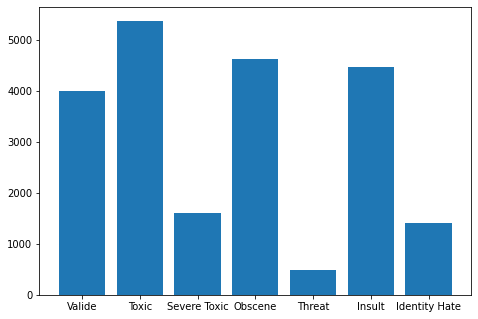

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['Valide', 'Toxic', 'Severe Toxic','Obscene', 'Threat', 'Insult', 'Identity Hate']
values = [
          len(data_resample[(data_resample['toxic'] == 0) & (data_resample['severe_toxic'] == 0) & (data_resample['obscene'] == 0) & (data_resample['threat'] == 0) & (data_resample['insult'] == 0) & (data_resample['identity_hate'] == 0)]),
          data_resample['toxic'].value_counts()[1],
          data_resample['severe_toxic'].value_counts()[1],
          data_resample['obscene'].value_counts()[1],
          data_resample['threat'].value_counts()[1],
          data_resample['insult'].value_counts()[1],
          data_resample['identity_hate'].value_counts()[1],
          ]
ax.bar(types,values)
plt.show()

Now we will create the td_idf with all values re-sample

In [30]:
df_idf = data_resample.copy()

In [31]:
%%time
# Apply prepare_string to all rows in 'tweets' column
df_idf['comment_text'] = df_idf['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
df_idf['comment_text'].replace('', np.nan, inplace=True)
df_idf.dropna(subset=['comment_text'], inplace=True)

df_idf.head(5)

CPU times: user 9.23 s, sys: 47.5 ms, total: 9.28 s
Wall time: 10.6 s


Creation of the model

In [32]:
tfIdfVectorizer = TfidfVectorizer()

X = tfIdfVectorizer.fit_transform(df_idf['comment_text']).toarray()
y = df_idf.drop(['id','comment_text'], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.025, random_state=0)

In [36]:
text_classifier = RandomForestClassifier(n_estimators=15, random_state=1)  
text_classifier.fit(X_train, y_train )

RandomForestClassifier(n_estimators=15, random_state=1)

In [37]:
print("Model score : {} ".format(text_classifier.score(X_test, y_test)))

Model score : 0.5836734693877551 


In [39]:
Y_test = text_classifier.predict(X_test)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in range(len(labels)):
  error, success, false_pos, false_neg = compareColumnPredictTarget(i,Y_test,y_test)
  print("For label : {0} we have {1} success and {2} errors ({3} false positive and {4} false negative).".format(labels[i], success, error, false_pos, false_neg))

For label : toxic we have 118 success and 26 errors (9 false positive and 17 false negative).
For label : severe_toxic we have 10 success and 27 errors (4 false positive and 23 false negative).
For label : obscene we have 89 success and 34 errors (11 false positive and 23 false negative).
For label : threat we have 2 success and 9 errors (0 false positive and 9 false negative).
For label : insult we have 85 success and 41 errors (20 false positive and 21 false negative).
For label : identity_hate we have 9 success and 22 errors (1 false positive and 21 false negative).
